In [11]:
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import shutil
import h5py
from scipy import io
import os
import glob
import pywt

preparing data for training

(1698, 600)


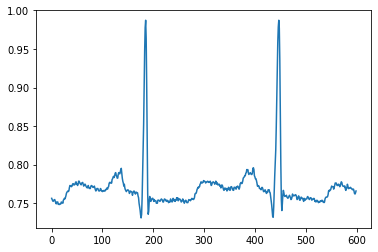

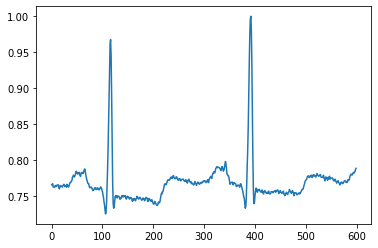

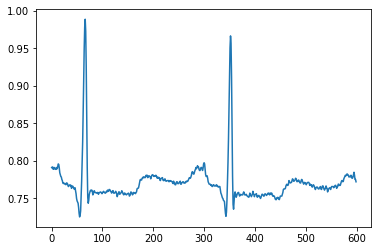

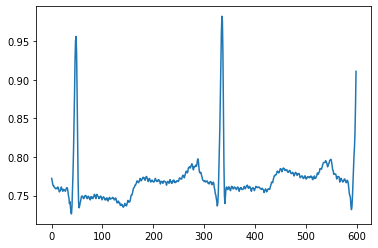

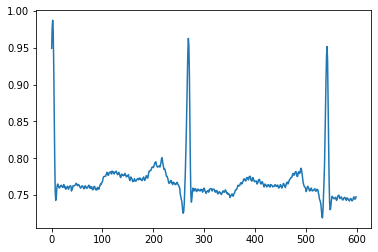

In [12]:
arr = []
for file in glob.glob('MLII/1 NSR/*.mat'):
    arr.append(file) 

arr = sorted(arr, key=lambda x:x[:])

l = 283
ll = 6
d = np.int(3600/ll)
stride = 1
data = []
for i in range(l):
    db = io.loadmat(arr[i])    
    for j in range(ll):
        data.append(db['val'][0, j*d:(j+1)*d]/np.amax(db['val'][0, :]))
data = np.asarray(data).reshape(l*ll, d)[:, ::stride]  

seq_in = data

#seq_in = []
#for i in range(len(data)):
#    cA, cD = pywt.dwt(data[i], 'db2')
#    seq_in.append(cD)
#seq_in = np.asarray(seq_in)
    
print (seq_in.shape)  

for i in range(5):
    plt.figure()
    plt.plot(seq_in[i, :])

GANLSTM for ECG data

In [13]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Input, Dense, Reshape, Dropout, LSTM, Bidirectional, ConvLSTM2D, MaxPooling2D
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.utils import plot_model
from keras.regularizers import l1_l2

In [14]:
class GAN():
    def __init__(self, rows):
        self.seq_length = rows
        self.latent_dim = 64
        self.disc_loss = []
        self.gen_loss = []
        
        optimizer = Adam(0.0008, 0.6)
        
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

        self.generator = self.build_generator()
        z = Input(shape=(self.seq_length, self.latent_dim,))
        generated_seq = self.generator(z)
        self.discriminator.trainable = False
        validity = self.discriminator(generated_seq)
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_discriminator(self):

        model = Sequential()
        model.add(Dense(512))
        model.add(Dropout(0.4))        
        model.add(LeakyReLU(alpha=0.2))         
        model.add(Dense(256))
        model.add(Dropout(0.4))        
        model.add(LeakyReLU(alpha=0.2)) 
        model.add(Dense(128))
        model.add(Dropout(0.4))        
        model.add(LeakyReLU(alpha=0.2)) 
        model.add(Dense(64))
        model.add(Dropout(0.4))        
        model.add(LeakyReLU(alpha=0.2))         
        model.add(Dense(1, activation='sigmoid'))

        seq = Input(shape=(self.seq_length,))
        validity = model(seq)

        return Model(seq, validity)
      
    def build_generator(self):

        model = Sequential()                
        model.add(Bidirectional(LSTM(16, activation='sigmoid', return_sequences=True, kernel_regularizer=l1_l2(l1=0.0, l2=0.0))))  
        model.add(Bidirectional(LSTM(8, activation='sigmoid', return_sequences=True, kernel_regularizer=l1_l2(l1=0.0, l2=0.0))))  
        model.add(Dense(1, activation='sigmoid'))
        model.add(Reshape((self.seq_length,)))   
        
        noise = Input(shape=(self.seq_length, self.latent_dim,))
        seq = model(noise)

        return Model(noise, seq)

    def train(self, epochs, batch_size=128, sample_interval=50):

        X_train = seq_in
        
        real = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        for epoch in range(epochs):

            idx = np.random.randint(0, X_train.shape[0], batch_size)
            real_seqs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.seq_length, self.latent_dim)) 
            gen_seqs = self.generator.predict(noise)

            d_loss_real = self.discriminator.train_on_batch(real_seqs, real)
            d_loss_fake = self.discriminator.train_on_batch(gen_seqs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            noise = np.random.normal(0, 1, (batch_size, self.seq_length, self.latent_dim))            
            g_loss = self.combined.train_on_batch(noise, real)

            if epoch % sample_interval == 0:
              print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
              self.disc_loss.append(d_loss[0])
              self.gen_loss.append(g_loss)
        self.plot_loss()            
            
    def plot_loss(self):
        
        plt.plot(self.disc_loss, c='red')
        plt.plot(self.gen_loss, c='blue')
        plt.title("GAN Loss per Epoch")
        plt.legend(['Discriminator', 'Generator'])
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.savefig('GAN_Loss_per_Epoch_final.png', transparent=True)
        plt.close()            

In [15]:
gan = GAN(rows=seq_in.shape[1])    
gan.train(epochs=500, batch_size=128, sample_interval=50)

0 [D loss: 1.396975, acc.: 29.30%] [G loss: 0.404779]


/home/lolo/miniconda3/envs/dnnComm/lib/python3.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


50 [D loss: 0.712013, acc.: 49.22%] [G loss: 0.705309]
100 [D loss: 0.695953, acc.: 50.78%] [G loss: 0.716759]
150 [D loss: 0.696828, acc.: 49.61%] [G loss: 0.698537]
200 [D loss: 0.705252, acc.: 43.36%] [G loss: 0.716511]
250 [D loss: 0.698796, acc.: 47.27%] [G loss: 0.700088]
300 [D loss: 0.693685, acc.: 50.00%] [G loss: 0.705414]
350 [D loss: 0.693861, acc.: 52.73%] [G loss: 0.694861]
400 [D loss: 0.696292, acc.: 46.88%] [G loss: 0.692270]
450 [D loss: 0.705433, acc.: 40.23%] [G loss: 0.707470]


generate synthetic ecg

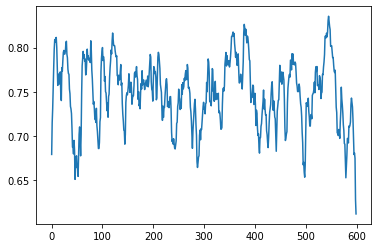

In [16]:
noise = np.random.normal(0, 1, (1, gan.seq_length, gan.latent_dim))
gen_seqs = gan.generator.predict(noise).reshape(gan.seq_length)
plt.figure()
plt.plot(gen_seqs)